# Generative Medical Image Segmentation

In [1]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import nn
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import run_model, print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 32
NUM_WORKERS = 0


/opt/homebrew/Caskroom/miniconda/base/envs/MBML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Dataloaders

In [2]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Model

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

class Encoder(nn.Module):                       # shared features
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc1 = double_conv(3,   16)
        self.enc2 = double_conv(16,  32)
        self.enc3 = double_conv(32,  64)
        self.enc4 = double_conv(64, 128)
        self.to_stats = nn.Sequential(           
            nn.Conv2d(128, 2*z_dim, 1),
            nn.AdaptiveAvgPool2d(1))
         
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x5 = self.to_stats(x4).flatten(1)
        mu, log_sig = x5.chunk(2, dim=-1)

        return mu, torch.exp(log_sig)
    
class Decoder(nn.Module):
    
    def __init__(self, z_dim=64, start_ch=128, img_size=32):
        super().__init__()
        self.img_size = img_size
        fsz = img_size // 16                             
        self.fc = nn.Linear(z_dim, start_ch * fsz * fsz)

        self.up1 = double_conv(start_ch, 128)
        self.up2 = double_conv(128,  64)
        self.up3 = double_conv(64,   32)
        self.up4 = double_conv(32,   16)

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear",
                                    align_corners=False)
        
        self.out_conv = nn.Conv2d(16, 1, 1)      

    def forward(self, z):
        B = z.size(0)
        fsz = self.img_size // 16
        x = self.fc(z).view(B, 128, fsz, fsz)

        x = self.up1(x)
        x = self.upsample(x)   
        x = self.up2(x) 
        x = self.upsample(x)   
        x = self.up3(x) 
        x = self.upsample(x)   
        x = self.up4(x) 
        x = self.upsample(x)  
        return torch.sigmoid(self.out_conv(x))          

                        

### Define VAE

In [4]:
# --- Define VAE ---
class VAE(nn.Module):
    def __init__(self, z_dim=6, input_dim=IMG_SIZE*IMG_SIZE*3):
        self.input_dim = input_dim
        self.output_dim = IMG_SIZE
        super().__init__()

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim, img_size=self.output_dim)
        self.z_dim = z_dim

    # Define the model p(y|z)p(z)
    def model(self, x, y=None):
        pyro.module("decoder", self.decoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)

            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            yhat = self.decoder.forward(z)

            if y is not None:
                pyro.sample("obs", 
                        dist.Bernoulli(yhat, validate_args=False).to_event(3), 
                        obs=y,)
            else:
                pyro.deterministic('obs', yhat.detach())

            return yhat

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y=None):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        batch_size = x.size(0)
        with pyro.plate("data", batch_size):

            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

### Test forward paas

In [5]:
vae = VAE().to(device)
output = vae.model(torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device))
print(output.shape)

torch.Size([1, 1, 32, 32])


### Run training

In [9]:
# --- Training the VAE ---
num_epochs = 10
test_frequency = 10
lr = 9e-5

vae = VAE(z_dim=24, input_dim=IMG_SIZE*IMG_SIZE*3)

# setup the optimizer
optimizer = Adam({"lr": lr})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

vae = run_model(vae, svi, train_loader, test_loader, num_epochs=num_epochs, test_frequency=test_frequency, device=device)

[Epoch 1]
Mean train loss: 761.4369
Mean test loss: 736.9381

[Epoch 2]
Mean train loss: 294.6685

[Epoch 3]
Mean train loss: 107.5558

[Epoch 4]
Mean train loss: 77.1540

[Epoch 5]
Mean train loss: 50.3489

[Epoch 6]
Mean train loss: 47.2682

[Epoch 7]
Mean train loss: 46.8692

[Epoch 8]
Mean train loss: 46.6436

[Epoch 9]
Mean train loss: 46.5656

[Epoch 10]
Mean train loss: 46.3595



In [13]:
# Model evaluation
vae.eval()
with torch.no_grad():
    print_losses(test_loader, vae, device)

BCE loss:
0.04

Average DICE score:
0.66

ELBO loss:
41.97472872746203


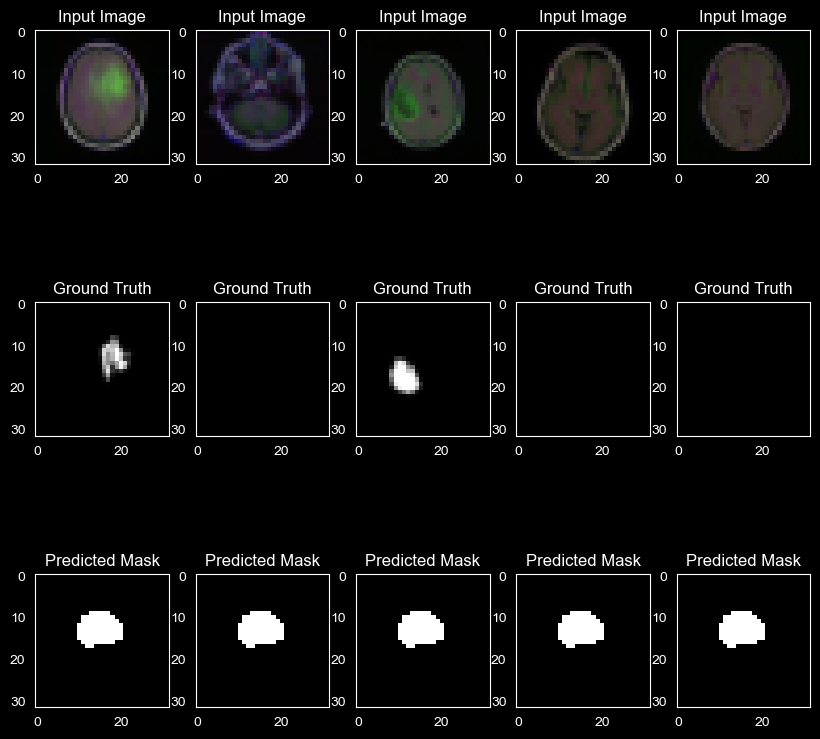

In [52]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = vae.decoder(vae.encoder(images)[0]) > 0.09
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow(images[i].transpose(1, 2, 0))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")


visualize_predictions(vae, test_loader)